# Imports

In [1]:
import numpy as np
import pandas as pd
import psycopg2 as pg
import sweetviz as sv
import seaborn as sns
import scikitplot as skplt
import warnings
import pickle
import json
import requests
import inflection
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
import lightgbm as lgb

C:\Users\Notebook\anaconda3\envs\insurance-cross-sell-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [2]:
def pie_chart(data,att,title,legend_title):
    
    def data_detail(pct, allvalues):
        absolute = int(pct/ 100.*np.sum(allvalues['response']))
        return "{:.0f}\n({:.1f}%)".format(absolute, pct)

    wedges, texts, autotexts = plt.pie( data = data,
                                       x = 'response',
                                       autopct = lambda pct: data_detail(pct, data),
                                       textprops = dict(color="w"))
    
    plt.legend( wedges, list(data[att]),
              title = legend_title,
              loc="center left",
              bbox_to_anchor = (1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    plt.title(title,fontsize = 15);
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
#     sns.set()
    
jupyter_settings()

def return_interest_perc(df,calls):
    perc = 100 * calls / len(df)
    return results[results['base_cum_perc'] <= perc]['real_cum_perc'].max()

def precision_at_k(data, k):
    
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k):

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']

def ranking_performance(model_name, x_validation, y_validation, yhat,top_k):

    data = x_validation.copy()
    data['response'] = y_validation.copy()

    # Propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score',ascending=False)
    
    return pd.DataFrame(
        {'Model Name': model_name,
        'Precision at K': precision_at_k(data,k=top_k),
        'Recall at K': recall_at_k(data,k=top_k)},
        index=[0]
    )

def classification_performance(model_name, y_test, y_pred):
    acc = accuracy_score(y_test,y_pred)
    pre = precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    f1s = f1_score(y_test,y_pred)
    
    return pd.DataFrame({
        'Model':model_name,
        'Accuracy' : acc,
        'Precision': pre,
        'Recall': rec,
        'F1 Score': f1s}, index=[0])

def data_preparation(data,dict_preparation):
    for att in list(dict_preparation['STANDARIZATION'].keys()):
        std = dict_preparation['STANDARIZATION'][att]
        data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['RESCALING'].keys()):
        for att in list(dict_preparation['RESCALING'][type_encode].keys()):
            std = dict_preparation['RESCALING'][type_encode][att]
            data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['ENCONDING'].keys()):
        for att in list(dict_preparation['ENCONDING'][type_encode].keys()):
            if type_encode == 'one_hot_enconding':
                prefix = dict_preparation['ENCONDING'][type_encode][att]
                columns = dict_preparation['ENCONDING'][type_encode][att]
                data = pd.get_dummies(data, prefix = prefix,columns=[columns])
            else:
                std = dict_preparation['ENCONDING'][type_encode][att]
                data.loc[:,att] = data.loc[:,att].map(std)
                
    # fillna
    data = data.fillna(0)
                
    return data

def cross_validation(data_train,k_fold,model_name, model,verbose):

    validation_size = int(round(data_train.shape[0]*0.2,0))
    
    precision_at_k_list = []
    recall_at_k_list = []

    for k in range(0,k_fold):

        start_validation = validation_size*k
        end_validation   = validation_size*(k+1)
        range_validation = arange(start_validation,end_validation)
        range_data       = arange(0,data_train.shape[0])

        validation = data_train.iloc[ start_validation:end_validation ]
        training = data_train[ ~isin(range_data,range_validation)]

        x_training = training.drop(['id','response'],axis=1)
        y_training = training['response'].copy()

        x_validation = validation.drop(['id','response'],axis=1)
        y_validation = validation['response'].copy()

        # model fit
        m = model.fit(x_training,y_training)

        # model predict
        y_hat = m.predict_proba(x_validation)
        
        data_val = x_validation.copy()
        data_val['response'] = y_validation.copy()

        # Propensity score
        data_val['score'] = y_hat[:,1].tolist()

        # sort clients by propensity score
        data_val = data_val.sort_values('score',ascending=False)
        
        precision_at_k_list.append(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        recall_at_k_list.append(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        
        if verbose:
            print(f'k_fold: {k}')
            print('Validation Size: {} | {} - {}'.format(validation.shape[0],start_validation,end_validation))
            print('Training Size: {}'.format(training.shape[0]))
            print('Total Size: {}'.format(validation.shape[0] + training.shape[0]))
            print('Total Original Size: {}'.format(data_train.shape[0]))
            print('Precision at K: {}'.format(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('Recall at K:    {}'.format(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('\n')
            
    return pd.DataFrame(
                        {'Model': model_name,
                         'Precision at K': round(np.mean(precision_at_k_list),4).astype(str) + ' +/- ' + round((np.std(precision_at_k_list)),4).astype(str),
                         'Recall at K':    round(np.mean(recall_at_k_list),4).astype(str) + ' +/- ' + round((np.std(recall_at_k_list)),4).astype(str)},
                          index=[0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load Dataset

In [3]:
# Credentials

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd =' cdspa'

# Connection with Database
conn_string = f'host={host} port={port} dbname={database} user={username} password={pwd}'
conn = pg.connect(conn_string)

# SQL Query
query = '''
    select * 
    from pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
'''

df = pd.read_sql(query, conn)
conn.close()
df.head()

id  gender  age  region_code  policy_sales_channel  id  driving_license vehicle_age vehicle_damage  id  previously_insured  annual_premium  vintage  response
0   7    Male   23         11.0                 152.0   7                1    < 1 Year            Yes   7                   0         23367.0      249         0
1  13  Female   41         15.0                  14.0  13                1    1-2 Year             No  13                   1         31409.0      221         0
2  18  Female   25         35.0                 152.0  18                1    < 1 Year             No  18                   1         46622.0      299         0
3  31  Female   26          8.0                 160.0  31                1    < 1 Year             No  31                   0          2630.0      136         0
4  39    Male   45          8.0                 124.0  39                1    1-2 Year            Yes  39                   0         42297.0      264         0

In [4]:
print('Rows: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))

Rows: 381109
Columns: 14


In [5]:
df_raw = df.loc[:,~df.columns.duplicated()]
df_raw.sample(3)

id  gender  age  region_code  policy_sales_channel  driving_license vehicle_age vehicle_damage  previously_insured  annual_premium  vintage  response
128879  267362    Male   25          8.0                 152.0                1    < 1 Year             No                   1         59447.0       92         0
70492   181884  Female   24         28.0                 152.0                1    < 1 Year             No                   1         37845.0      171         0
342809   73602    Male   23         28.0                 152.0                1    < 1 Year            Yes                   0          2630.0      285         0

In [6]:
print('Rows: {}'.format(df_raw.shape[0]))
print('Columns: {}'.format(df_raw.shape[1]))

Rows: 381109
Columns: 12


# Data Description

In [7]:
df2 = df_raw.copy()

## Data Dimension

In [8]:
print('Rows: {}'.format(df2.shape[0]))
print('Columns: {}'.format(df2.shape[1]))

Rows: 381109
Columns: 12


## Data Types

In [9]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## Change Types

In [10]:
# region_code
df2['region_code'] = df2['region_code'].astype('int64')

# policy_sales_channel 
df2['policy_sales_channel'] = df2['policy_sales_channel'].astype('int64')

In [11]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## Check NA

In [12]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## Data Descriptive

In [13]:
df2.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [14]:
num_attributes = df2[['age','annual_premium','vintage']]
cat_attributes = df2[['gender','driving_license','vehicle_age','vehicle_damage','previously_insured','policy_sales_channel','region_code']]

### Numerical atributes

In [15]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']

m

attributes     min       max     range          mean        median           std      skew   kurtosis
0             age    20.0      85.0      65.0     38.822584     38.822584     15.511591  0.672539  -0.565655
1  annual_premium  2630.0  540165.0  537535.0  30564.389581  30564.389581  17213.132474  1.766087  34.004569
2         vintage    10.0     299.0     289.0    154.347397    154.347397     83.671194  0.003030  -1.200688

### Categorical atributes

In [16]:
for i in cat_attributes.columns:
    print(f'{i}: \nNumber of categories: {cat_attributes[i].unique().shape[0]}\nCategories: {sorted(cat_attributes[i].unique())}\n')

gender: 
Number of categories: 2
Categories: ['Female', 'Male']

driving_license: 
Number of categories: 2
Categories: [0, 1]

vehicle_age: 
Number of categories: 3
Categories: ['1-2 Year', '< 1 Year', '> 2 Years']

vehicle_damage: 
Number of categories: 2
Categories: ['No', 'Yes']

previously_insured: 
Number of categories: 2
Categories: [0, 1]

policy_sales_channel: 
Number of categories: 155
Categories: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 143, 144, 14

# Feature Engineering

In [17]:
df3 = df2.copy()

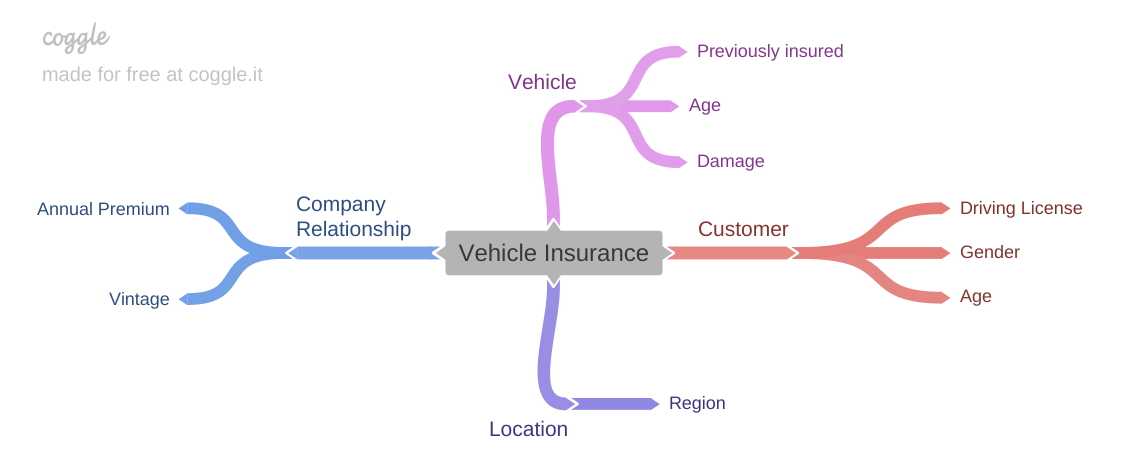

In [18]:
Image('img/Vehicle_Insurance.png')

## Hyphotesis Mind Map

### Customer's Hyphotesis

1. Customers over 40 years old are 50% more interest in vehicle insurance

### Vehicle's Hyphotesis

1. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

### Company Relationship's Hyphotesis

1. Customer with less than 30 days in relation with the company are 40% more interest in adquire the vehicle insurance

## Feature Criation

In [19]:
df3.head()

id  gender  age  region_code  policy_sales_channel  driving_license vehicle_age vehicle_damage  previously_insured  annual_premium  vintage  response
0   7    Male   23           11                   152                1    < 1 Year            Yes                   0         23367.0      249         0
1  13  Female   41           15                    14                1    1-2 Year             No                   1         31409.0      221         0
2  18  Female   25           35                   152                1    < 1 Year             No                   1         46622.0      299         0
3  31  Female   26            8                   160                1    < 1 Year             No                   0          2630.0      136         0
4  39    Male   45            8                   124                1    1-2 Year            Yes                   0         42297.0      264         0

In [20]:
# vericle_age
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                     'between_1_2_year' if x == '1-2 Year' else 
                                                     'over_2_years')

In [21]:
df3.head()

id  gender  age  region_code  policy_sales_channel  driving_license       vehicle_age vehicle_damage  previously_insured  annual_premium  vintage  response
0   7    Male   23           11                   152                1     bellow_1_year            Yes                   0         23367.0      249         0
1  13  Female   41           15                    14                1  between_1_2_year             No                   1         31409.0      221         0
2  18  Female   25           35                   152                1     bellow_1_year             No                   1         46622.0      299         0
3  31  Female   26            8                   160                1     bellow_1_year             No                   0          2630.0      136         0
4  39    Male   45            8                   124                1  between_1_2_year            Yes                   0         42297.0      264         0

# Data Filtering

In [22]:
df4 = df3.copy()

# Exploratory Data Analysis

In [23]:
df5 = df4.copy()

In [24]:
# report = sv.analyze(df4)
# report.show_html()

## Univariate Analysis

### Numerial Variables

#### Age

- Although people between 20 and 30 years old are not usually interest, people between 40 and 50 years old are offen intereset

- Numerical variable with no normal distribution, no outiliers: **MIN MAX SCALER**

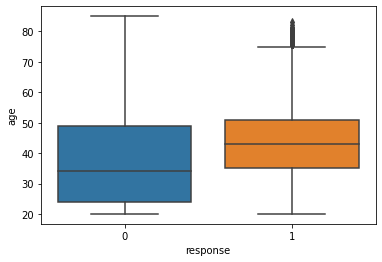

In [25]:
# 'age'
sns.boxplot(x='response',y='age',data=df5);

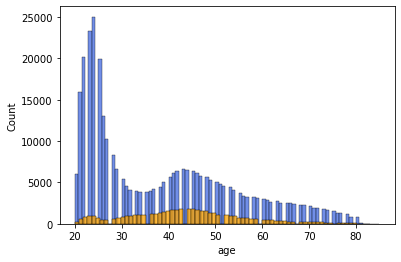

In [26]:
aux00 = df5.loc[df5['response'] == 0, 'age']
aux01 = df5.loc[df5['response'] == 1, 'age']
sns.histplot(aux00,color='royalblue')
sns.histplot(aux01,color='orange');

#### Annual Premium

- The distribuiton of annual premium are very similuar to interest and not interest people. Only the scale of this distribution are diferent

- Numerical variable with normal distribution: **STANDARIZATION**

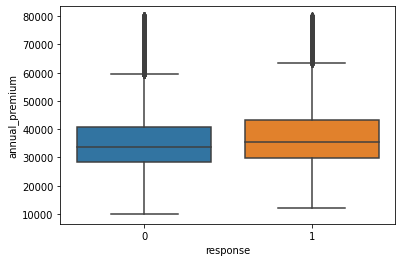

In [27]:
# 'annual_premium'
aux = df5[(df5['annual_premium'] < 80000) & (df5['annual_premium'] > 10000)]
sns.boxplot(x='response',y='annual_premium',data=aux);

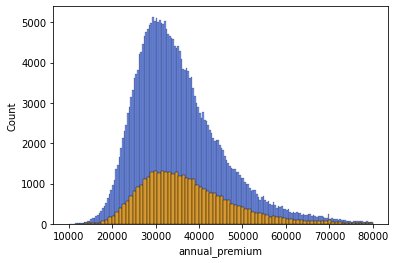

In [28]:
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00,color='royalblue')
sns.histplot(aux01,color='orange');

#### Vintage

- The vintage (days that the customer is related with the company) is uniform distribuited
- Numerical variable with no normal distruibution, no outliers: **MIN MAX SCALER**

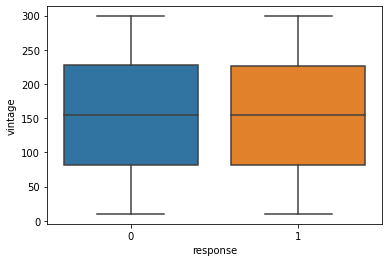

In [29]:
# 'annual_premium'
sns.boxplot(x='response',y='vintage',data=df5);

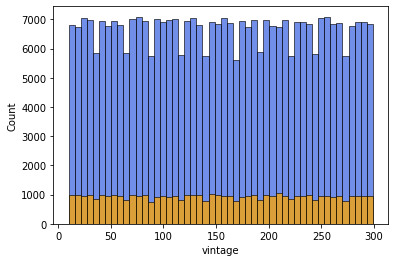

In [30]:
aux00 = df4.loc[df5['response'] == 0, 'vintage']
aux01 = df4.loc[df5['response'] == 1, 'vintage']
sns.histplot(aux00,color='royalblue',bins=50)
sns.histplot(aux01,color='orange',bins=50);

### Categorical Variables

#### Gender

- Mens represents 54% of the elevible customer but represents 61% of whole car insurance interest

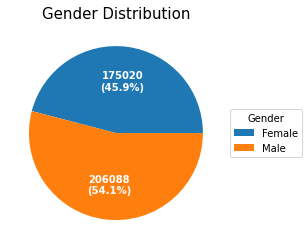

In [31]:
aux2 = pd.DataFrame(df5[['gender','response']].groupby('gender').count()).reset_index()
pie_chart(aux2,'gender',"Gender Distribution",'Gender')

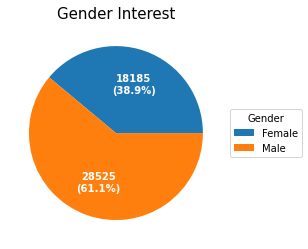

In [32]:
# pie plot
# ax = plt.figure(figsize=(15,6))
aux2 = pd.DataFrame(df5[['gender','response']].groupby('gender').sum()).reset_index()
pie_chart(aux2,'gender',"Gender Interest",'Gender')

#### Driving License

- The majority people has driving license

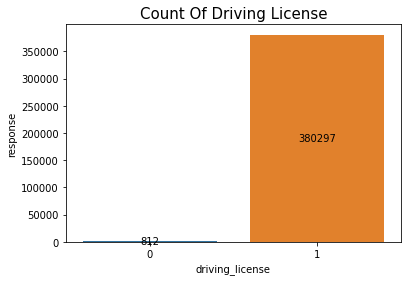

In [33]:
aux1 = df5[['driving_license','response']].groupby('driving_license').count().reset_index()
g = sns.barplot(x = 'driving_license', y = 'response', data = aux1)
g.set_title('Count Of Driving License',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'center',fontsize='medium',fmt='%.0f')

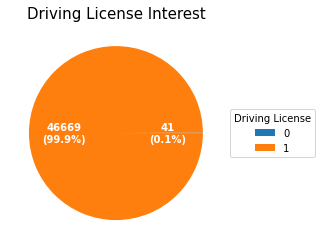

In [34]:
# pie plot
aux1 = pd.DataFrame(df5[['driving_license','response']].groupby('driving_license').sum()).reset_index()
pie_chart(aux1,'driving_license',"Driving License Interest",'Driving License')

#### Region Code

- No region code has a significant majority of interest

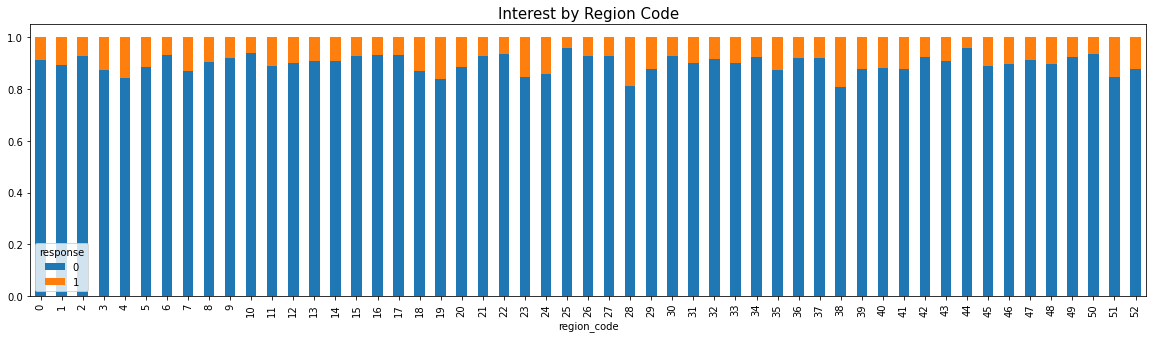

In [35]:
df_grouped = df5[["region_code", "response"]].groupby('region_code').value_counts(normalize=True).unstack('response')
g = df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Region Code',fontsize=15);

#### Previously Insured

- Although the similar number of people previously and not previously car insured, the people that haven't previoulsly insurance are the most interested

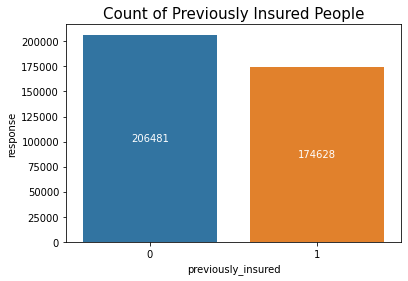

In [36]:
aux1 = df5[['previously_insured','response']].groupby('previously_insured').count().reset_index()
g = sns.barplot(x = 'previously_insured', y = 'response', data = aux1)
g.set_title('Count of Previously Insured People',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

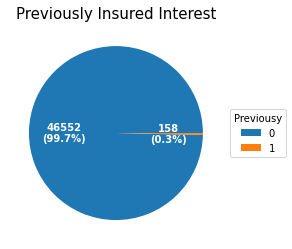

In [37]:
aux1 = pd.DataFrame(df5[['previously_insured','response']].groupby('previously_insured').sum()).reset_index()
pie_chart(aux1,'previously_insured',"Previously Insured Interest",'Previousy')

#### Vericle Age

- The majority of people has cars bellow 2 years old, but the more interested people has cars over 2 years

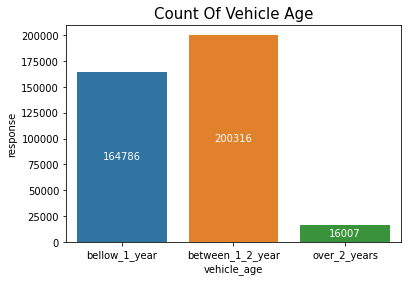

In [38]:
aux1 = df5[["vehicle_age", "response"]].groupby('vehicle_age').count().reset_index()
g = sns.barplot(x = 'vehicle_age', y = 'response', data = aux1)
g.set_title('Count Of Vehicle Age',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

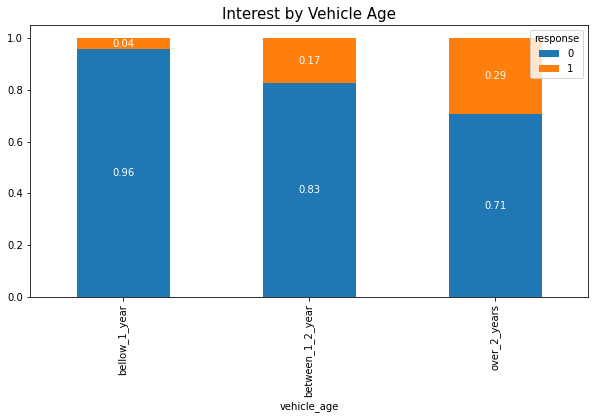

In [39]:
# 'vehicle_age'
df_grouped = df5[["vehicle_age", "response"]].groupby('vehicle_age').value_counts(normalize=True).unstack('response')
g = df_grouped.plot.bar(stacked=True,figsize=(10,5));
g.set_title('Interest by Vehicle Age',fontsize=15)

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.2f')

#### Policy Sales Channel

- Although the quantity diference of sales channel, no channel has the majority of the interest people

In [40]:
# policy_sales_channel
aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
aux1 = aux0[aux0['response'] > 40.0]### 4.1.6 Previously Insured

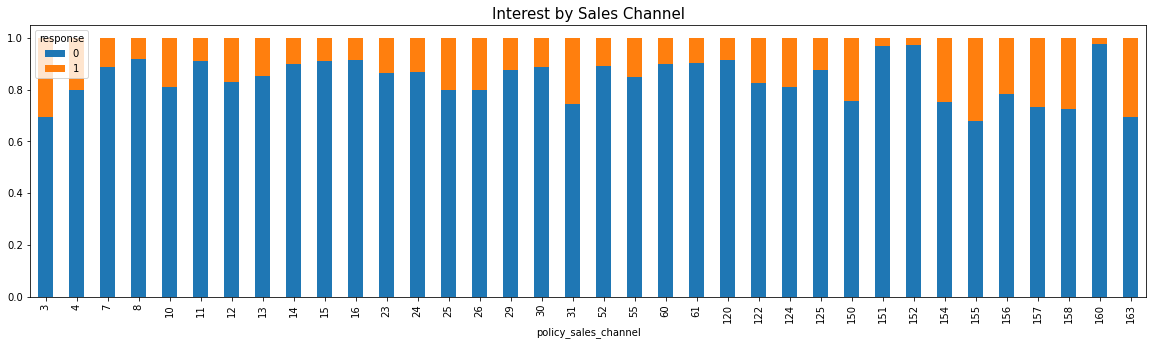

In [41]:
aux = df5[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

# 'policy_sales_channel'
aux2 = df5[df5['policy_sales_channel'].isin(aux['policy_sales_channel'])]
df_grouped = aux2[["policy_sales_channel", "response"]].groupby('policy_sales_channel').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Sales Channel',fontsize=15);

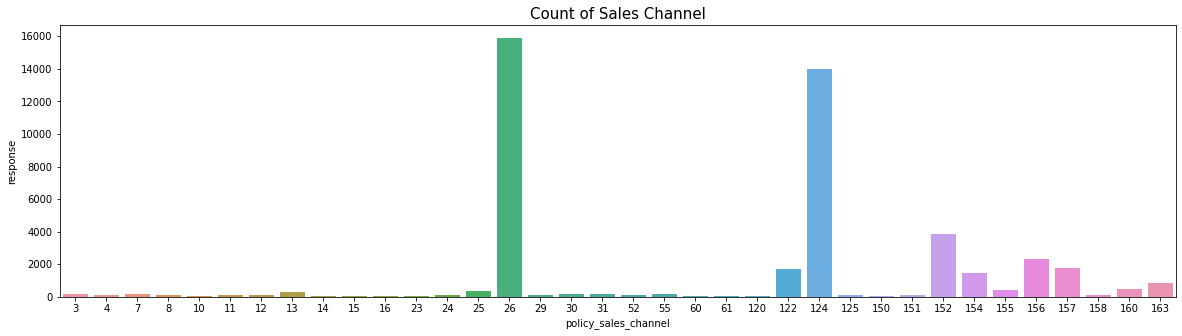

In [42]:
fig = plt.figure(figsize=(20,5))
aux = df5[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

sns.barplot(data=aux,x='policy_sales_channel',y='response');
plt.title('Count of Sales Channel',fontsize=15);

#### Vehicle Damage

- Although tha simular number of damage and not damage vehicles, people that are more interest has a vehicle damage in the past

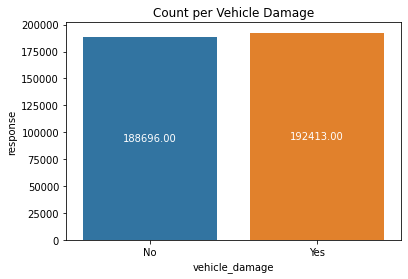

In [43]:
# 'vehicle_damage'
aux1 = df5[['vehicle_damage','response']].groupby('vehicle_damage').count().reset_index()
g = sns.barplot(x = 'vehicle_damage', y = 'response', data = aux1)
g.set_title('Count per Vehicle Damage')

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.2f')

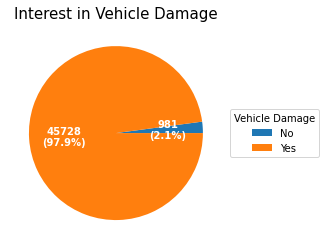

In [44]:
# pie plot
aux1 = pd.DataFrame(df5[['vehicle_damage','response']].groupby('vehicle_damage').sum()).reset_index()
pie_chart(aux1,'vehicle_damage',"Interest in Vehicle Damage",'Vehicle Damage')

## Bivariate Analysis

### H1. Customers over 40 years old are 50% more interest in vehicle insurance

- **True**, customer over 40 years old are 95% more interest in vehicle insurance than others

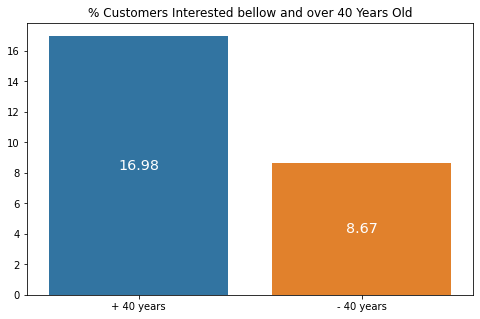

In [45]:
aux = df5[['age','response']].copy()
aux['old'] = df5['age'].apply(lambda x: '+ 40 years' if x > 40 else '- 40 years')
aux = aux.groupby('old').agg(total=('response','count'),interest=('response','sum')).reset_index()
aux['perc'] = 100 * aux['interest'] / aux['total']
aux['diff'] = aux['perc'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x=['+ 40 years','- 40 years'], y=[aux.loc[0,'perc'],aux.loc[1,'perc']])
plt.title('% Customers Interested bellow and over 40 Years Old')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

In [46]:
aux

old   total  interest       perc   diff
0  + 40 years  164485     27930  16.980272    NaN
1  - 40 years  216624     18780   8.669400  95.86

### H2. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

- **False**, customer with newer vehicle are 76% less interest in adquive the insurance

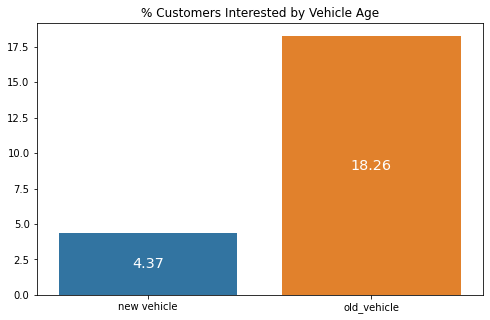

In [47]:
aux = df5[['vehicle_age','response']].copy()
aux['vehicle_age'] = aux['vehicle_age'].apply(lambda x: 'new vehicle' if x == 'bellow_1_year' else 'old_vehicle')
aux = aux.groupby('vehicle_age').agg(total=('response','count'),interest=('response','sum')).reset_index()
aux['perc'] = 100 * aux['interest'] / aux['total']
aux['diff'] = aux['perc'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x=['new vehicle','old_vehicle'], y=[aux.loc[0,'perc'],aux.loc[1,'perc']])
plt.title('% Customers Interested by Vehicle Age')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

In [48]:
aux

vehicle_age   total  interest       perc   diff
0  new vehicle  164786      7202   4.370517    NaN
1  old_vehicle  216323     39508  18.263430 -76.07

### H3. Customer with more days in relation with the company are more interest in adquire the vehicle insurance

- **False**, as longer as the customer relationship with the company are, the lower is the interest

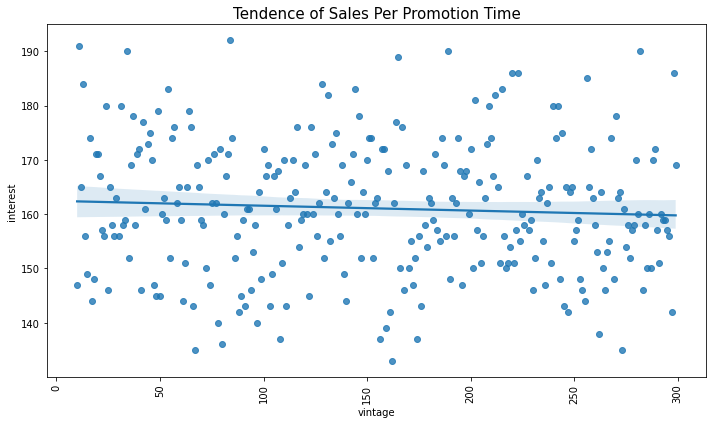

In [49]:
aux = df5[['vintage','response']].copy()
aux = aux.groupby('vintage').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(10,6))
sns.regplot(x='vintage', y='interest',data=aux);
plt.xticks(rotation=90);
plt.title('Tendence of Sales Per Promotion Time',fontsize=15)
plt.tight_layout()

# Data Preparation

In [50]:
df6 = df5.copy()

## Split Datasets

In [51]:
X = df6.drop(['response'],axis=1)
y = df6['response'].copy()

In [52]:
X_train_raw, X_test_raw, y_train, y_test = ms.train_test_split(X, y, test_size=0.2)

df6 = pd.concat([X_train_raw, y_train], axis=1)

In [54]:
print('Total Dimension:                    {}'.format(X.shape[0]))
print('Training Model Dataset Dimension:   {} ({}%)'.format(X_train_raw.shape[0],round((X_train_raw.shape[0]/X.shape[0])*100,2)))
print('Test Model Dataset Dimension: {} ({}%)'.format(X_test_raw.shape[0],round((X_test_raw.shape[0]/X.shape[0])*100,2)))

# print('\nTotal Training Dimension:           {}'.format(X_train_raw.shape[0]))
# print('Training Model Dataset Dimension:   {} ({}%)'.format(x_train.shape[0],round((x_train.shape[0]/X_train_raw.shape[0])*100,2)))
# print('Validation Model Dataset Dimension: {} ({}%)'.format(x_validation.shape[0],round((x_validation.shape[0]/X_train_raw.shape[0])*100,2)))

Total Dimension:                    381109
Training Model Dataset Dimension:   304887 (80.0%)
Test Model Dataset Dimension: 76222 (20.0%)


## Standardization

In [55]:
ss = pp.StandardScaler()

## annual_premium
df6['annual_premium'] = ss.fit_transform(df6[['annual_premium']].values)
pickle.dump(ss,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\annual_premium_scaler.pkl','wb'))

## Rescaling

In [56]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

## age
df6['age'] = mms_age.fit_transform( df6[['age']].values )
pickle.dump(mms_age,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\age_scaler.pkl','wb'))

## vintage
df6['vintage'] = mms_vintage.fit_transform( df6[['vintage']].values )
pickle.dump(mms_vintage,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\vintage_scaler.pkl','wb'))

## Encoder

### One Hot Enconding

In [57]:
## vehicle_age
df6 = pd.get_dummies(df6, prefix='vehicle_age',columns=['vehicle_age'])

### Target Enconding

In [58]:
# gender 
target_encode_gender = df6.groupby('gender')['response'].mean()
df6.loc[:,'gender'] = df6['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\gender_scaler.pkl','wb'))

# region_code 
target_encode_region_code = df6.groupby('region_code')['response'].mean()
df6.loc[:,'region_code'] = df6['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\region_code_scaler.pkl','wb'))

# vehicle damage
target_encode_vehicle_damage = df6.groupby('vehicle_damage')['response'].mean()
df6.loc[:,'vehicle_damage'] = df6['vehicle_damage'].map(target_encode_vehicle_damage)
pickle.dump(target_encode_vehicle_damage,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\vehicle_damage_scaler.pkl','wb'))

### Frequency Enconding

In [59]:
## policy_sales_channel 
fe_policy_sales_channel = df6.groupby('policy_sales_channel').size()/len(df6)
df6.loc[:,'policy_sales_channel'] = df6['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\features\\policy_sales_channel_scaler.pkl','wb'))

In [60]:
df6.head()

id    gender       age  region_code  policy_sales_channel  driving_license  vehicle_damage  previously_insured  annual_premium   vintage  response  vehicle_age_bellow_1_year  vehicle_age_between_1_2_year  vehicle_age_over_2_years
81812   271733  0.138686  0.046154     0.187717              0.353708                1        0.005330                   1       -0.103232  0.096886         0                          1                             0                         0
373836  322819  0.138686  0.046154     0.129557              0.353708                1        0.238055                   1        0.310410  0.740484         0                          1                             0                         0
357148  189974  0.138686  0.553846     0.187717              0.028056                1        0.238055                   0       -1.618179  0.314879         0                          0                             0                         1
318950  262639  0.104312  0.476923     0.103546              0.193996                1        0.005330                   1       -0.207685  0.878893         0                          0                             1                         0
148007   40211  0.138686  0.369231     0.080656              0.353708                1        0.005330                   1       -1.618179  0.346021         0                          0                             1                         0

## Test Preparation

In [61]:
X_test_raw.head()

id  gender  age  region_code  policy_sales_channel  driving_license       vehicle_age vehicle_damage  previously_insured  annual_premium  vintage
304666  148444  Female   22           32                   152                1     bellow_1_year            Yes                   0         33351.0      265
33667   268921    Male   35            8                   124                1  between_1_2_year            Yes                   0         33191.0      202
360709  218582  Female   24           34                   152                1     bellow_1_year            Yes                   0          2630.0      121
148764   46230  Female   26           28                   152                1     bellow_1_year            Yes                   0         24923.0      231
129711  274285  Female   37           26                   156                1  between_1_2_year            Yes                   0         29340.0      235

In [62]:
dict_preparation = {
    'STANDARIZATION':{
        'annual_premium':ss
    },
    'RESCALING': {
        'min_max_scaler':{
            'age':    mms_age,
            'vintage':mms_vintage
        }
    },
    'ENCONDING':{
        'one_hot_enconding':{
            'vehicle_age':'vehicle_age'
        },
        'target_enconding':{
            'gender':         target_encode_gender,
            'region_code':    target_encode_region_code,
            'vehicle_damage': target_encode_vehicle_damage
        },
        'frequency_encoding':{
            'policy_sales_channel':fe_policy_sales_channel
        }
    }
}

In [63]:
def data_preparation(df,dict_preparation):
    
    data = df.copy()
    for att in list(dict_preparation['STANDARIZATION'].keys()):
        std = dict_preparation['STANDARIZATION'][att]
        data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['RESCALING'].keys()):
        for att in list(dict_preparation['RESCALING'][type_encode].keys()):
            std = dict_preparation['RESCALING'][type_encode][att]
            data.loc[:,att] = std.transform(data[[att]].values)

    for type_encode in list(dict_preparation['ENCONDING'].keys()):
        for att in list(dict_preparation['ENCONDING'][type_encode].keys()):
            if type_encode == 'one_hot_enconding':
                prefix = dict_preparation['ENCONDING'][type_encode][att]
                columns = dict_preparation['ENCONDING'][type_encode][att]
                data = pd.get_dummies(data, prefix = prefix,columns=[columns])
            else:
                std = dict_preparation['ENCONDING'][type_encode][att]
                data.loc[:,att] = data.loc[:,att].map(std)
                
    # fillna
    data = data.fillna(0)
                
    return data

In [64]:
x_test = data_preparation(X_test_raw,dict_preparation)

In [65]:
x_test.head()

id    gender       age  region_code  policy_sales_channel  driving_license  vehicle_damage  previously_insured  annual_premium   vintage  vehicle_age_bellow_1_year  vehicle_age_between_1_2_year  vehicle_age_over_2_years
304666  148444  0.104312  0.030769     0.087248              0.353708                1        0.238055                   0        0.161580  0.882353                          1                             0                         0
33667   268921  0.138686  0.230769     0.095978              0.193996                1        0.238055                   0        0.152311  0.664360                          0                             1                         0
360709  218582  0.104312  0.061538     0.075542              0.353708                1        0.238055                   0       -1.618179  0.384083                          1                             0                         0
148764   46230  0.104312  0.092308     0.187717              0.353708                1        0.238055                   0       -0.326679  0.764706                          1                             0                         0
129711  274285  0.104312  0.261538     0.072318              0.028056                1        0.238055                   0       -0.070789  0.778547                          0                             1                         0

# Feature Selection

## Feature Importance

In [66]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = df6[['response']]
forest.fit(x_train_n, y_train_n)

# Print the feature ranking
print('Feature ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df= pd.concat([df, aux], axis=0)

df = df.sort_values('importance',ascending=False)
df

Feature ranking


feature  importance
0                       vintage    0.271412
0                annual_premium    0.243738
0                           age    0.166482
0                   region_code    0.104704
0                vehicle_damage    0.067243
0          policy_sales_channel    0.061588
0            previously_insured    0.056747
0     vehicle_age_bellow_1_year    0.014542
0  vehicle_age_between_1_2_year    0.006131
0                        gender    0.004805
0      vehicle_age_over_2_years    0.002113
0               driving_license    0.000495

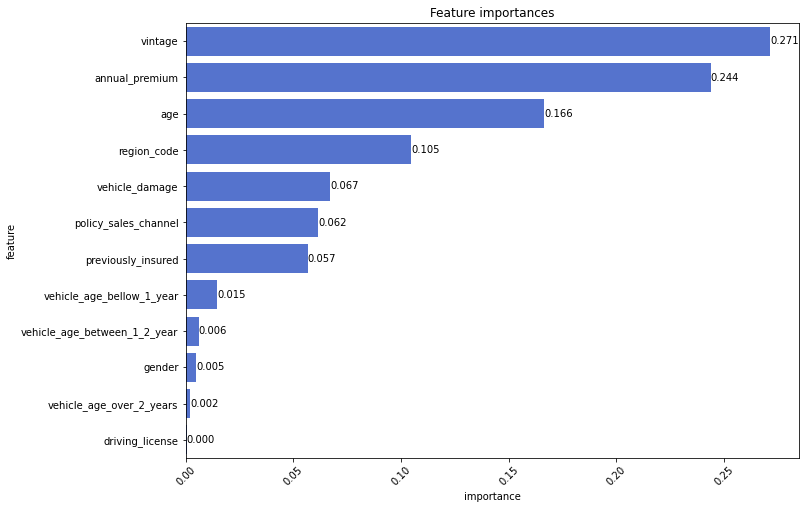

In [67]:
# plot the impurity-based feature importance of the forest

plt.figure(figsize=(11,8))
plt.title('Feature importances')
g = sns.barplot(x='importance',y='feature',data=df,color='royalblue', orient='h')
plt.xticks(rotation=45)

for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.3f')

# Machine Learning

In [68]:
cols_selected = [
                'vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']

x_train = df6[cols_selected]

## KNN

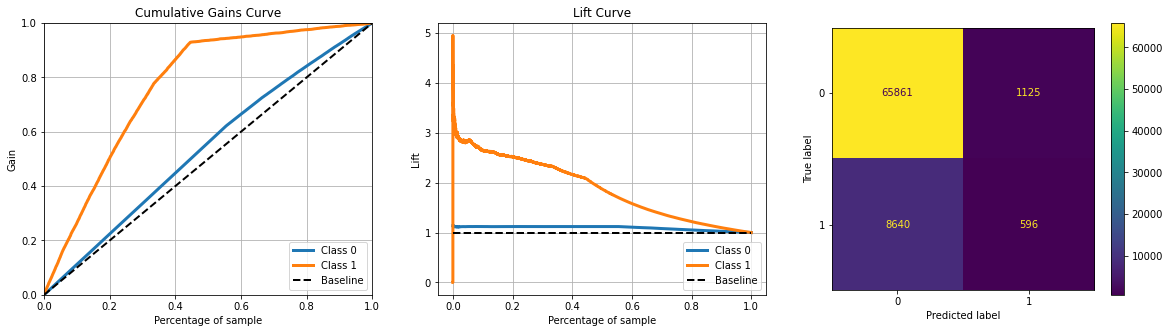

In [69]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_knn = knn_model.predict_proba(x_test[cols_selected])
# performance
knn_result_rank = ranking_performance('KNN', x_test, y_test,y_score_knn,20000)

# ==== Model Prediction 
# model prediction
y_pred_knn = knn_model.predict(x_test[cols_selected])
# performance
knn_result_class = classification_performance('KNN', y_test, y_pred_knn)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_test,y_score_knn,ax=ax[0])
skplt.metrics.plot_lift_curve(y_test,y_score_knn,ax=ax[1]);
plot_confusion_matrix(knn_model, x_test[cols_selected],y_test,ax=ax[2])  
plt.show() 

## Logistic Regressor

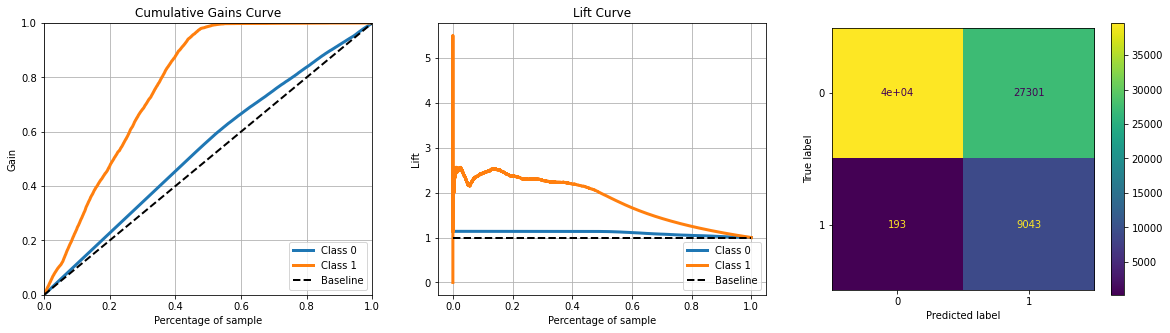

In [70]:
# model definition
n0 = y_train.shape[0]/(2*(y_train.shape[0] - y_train.sum()))
n1 = y_train.shape[0]/(2*(y_train.sum()))
lr_model = lm.LogisticRegression(class_weight={0:n0,1:n1})

# model training 
lr_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_lr = lr_model.predict_proba(x_test[cols_selected])
# performance
lr_result_rank = ranking_performance('Logistic Regression', x_test, y_test,y_score_lr,20000)

# ==== Model Prediction 
# model prediction
y_pred_lr = lr_model.predict(x_test[cols_selected])
# performance
lr_result_class = classification_performance('Logistic Regression', y_test, y_pred_lr)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_test,y_score_lr,ax=ax[0])
skplt.metrics.plot_lift_curve(y_test,y_score_lr,ax=ax[1]);
plot_confusion_matrix(lr_model, x_test[cols_selected],y_test,ax=ax[2])  
plt.show() 

## Extra Trees

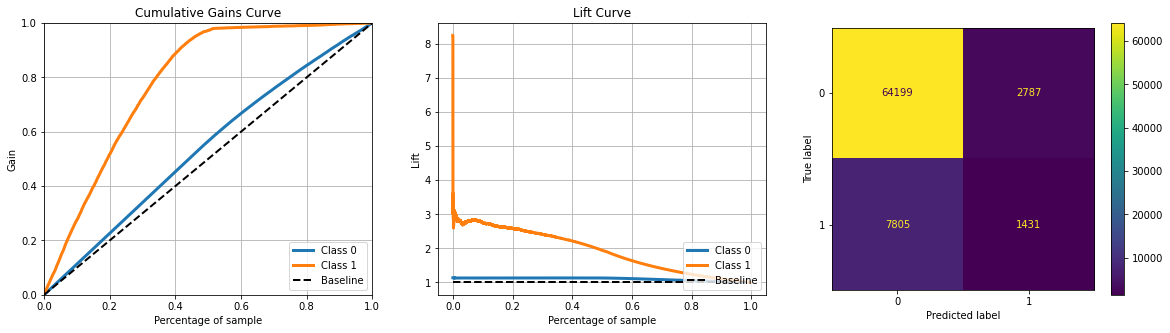

In [71]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)

# model fit
et_model.fit(x_train, y_train)

# ==== Model Score 
# model prediction
y_score_et = et_model.predict_proba(x_test[cols_selected])
# performance
et_result_rank = ranking_performance('Extra Tree', x_test, y_test,y_score_et,20000)

# ==== Model Prediction 
# model prediction
y_pred_et = et_model.predict(x_test[cols_selected])
# performance
et_result_class = classification_performance('Extra Trees', y_test, y_pred_et)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_test,y_score_et,ax=ax[0])
skplt.metrics.plot_lift_curve(y_test,y_score_et,ax=ax[1]);
plot_confusion_matrix(et_model, x_test[cols_selected],y_test,ax=ax[2])  
plt.show() 

## XGBoost

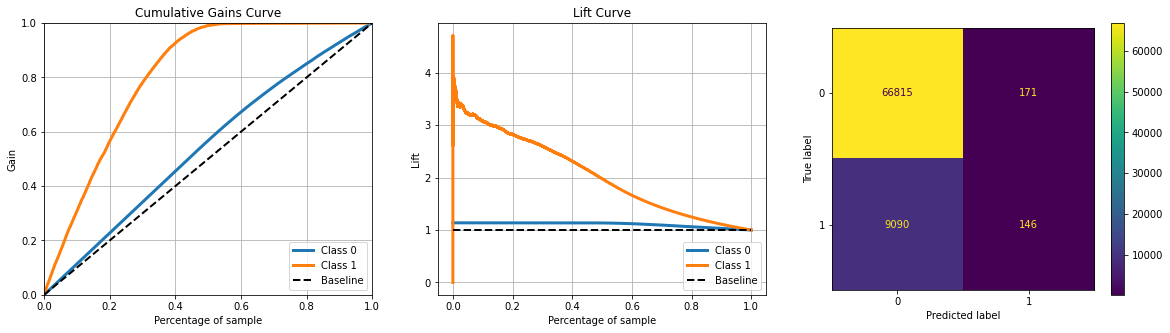

In [72]:
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 100)

# model fit
xgb_model.fit(x_train,y_train)

# ==== Model Score 
# model prediction
y_score_xgb = xgb_model.predict_proba(x_test[cols_selected])
# performance
xgb_result_rank = ranking_performance('XGBoost', x_test, y_test,y_score_xgb,20000)

# ==== Model Prediction 
# model prediction
y_pred_xgb = xgb_model.predict(x_test[cols_selected])
# performance
xgb_result_class = classification_performance('XGBoost', y_test, y_pred_xgb)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_test,y_score_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_test,y_score_xgb,ax=ax[1]);
plot_confusion_matrix(xgb_model, x_test[cols_selected],y_test,ax=ax[2])  
plt.show() 

## LightGBM

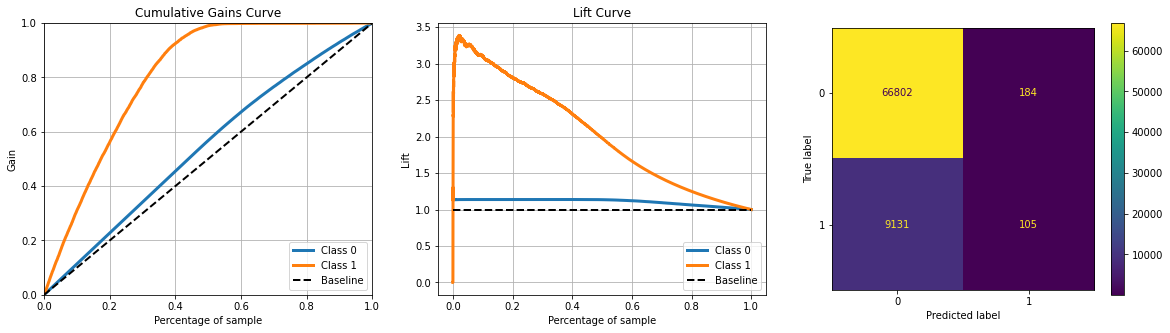

In [73]:
# model definition
lgbm_model = lgb.LGBMClassifier(n_estimators = 600)

# model fit
lgbm_model.fit(x_train,y_train)

# ==== Model Score 
# model prediction
y_score_lgb = lgbm_model.predict_proba(x_test[cols_selected])
# performance
lgb_result_rank = ranking_performance('LightGMB', x_test, y_test,y_score_lgb,20000)

# ==== Model Prediction 
# model prediction
y_pred_lgb = lgbm_model.predict(x_test[cols_selected])
# performance
lgb_result_class = classification_performance('LightGMB', y_test, y_pred_lgb)

# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_test,y_score_lgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_test,y_score_lgb,ax=ax[1]);
plot_confusion_matrix(lgbm_model, x_test[cols_selected],y_test,ax=ax[2])  
plt.show() 

## Model Single Performance

In [123]:
class_metrics

Model  Accuracy  Precision    Recall  F1 Score
0                  KNN  0.871887   0.346310  0.064530  0.108789
0  Logistic Regression  0.639290   0.248817  0.979104  0.396797
0          Extra Trees  0.861037   0.339260  0.154937  0.212725
0              XGBoost  0.878500   0.460568  0.015808  0.030566
0             LightGMB  0.877791   0.363322  0.011369  0.022047

In [124]:
rank_metrics = pd.concat([knn_result_rank, lr_result_rank, et_result_rank, xgb_result_rank,lgb_result_rank])
class_metrics = pd.concat([knn_result_class, lr_result_class, et_result_class, xgb_result_class,lgb_result_class])

rank_metrics.set_index('Model Name', inplace=True)
class_metrics.set_index('Model', inplace=True)

In [120]:
rank_metrics.style.background_gradient(cmap='Greens')

In [125]:
class_metrics.style.background_gradient(cmap='Greens')

## Cross Validation

In [126]:
def transformation_scalers(data):

    df = data.copy()
    
    ###### Standardization
    ss = pp.StandardScaler()
    # annual_premium
    ss.fit(df[['annual_premium']].values)
    
    ###### Rescaling
    mms_age = pp.MinMaxScaler()
    mms_vintage = pp.MinMaxScaler()
    
    # age
    mms_age.fit( df[['age']].values )
    
    # vintage
    mms_vintage.fit( df[['vintage']].values )
    
    ###### Encoder
    ### One Hot Enconding
    # vehicle_age
    # -> Direct transformation on dataset
    
    ### Target Enconding
    # gender 
    target_encode_gender = df.groupby('gender')['response'].mean()
    
    # region_code 
    target_encode_region_code = df.groupby('region_code')['response'].mean()

    # vehicle damage
    target_encode_vehicle_damage = df.groupby('vehicle_damage')['response'].mean()

    ###### Frequency Enconding
    # policy_sales_channel 
    fe_policy_sales_channel = df.groupby('policy_sales_channel').size()/len(df)
    
    dict_preparation = {
    'STANDARIZATION':{
        'annual_premium':ss
    },
    'RESCALING': {
        'min_max_scaler':{
            'age':    mms_age,
            'vintage':mms_vintage
        }
    },
    'ENCONDING':{
        'one_hot_enconding':{
            'vehicle_age':'vehicle_age'
        },
        'target_enconding':{
            'gender':         target_encode_gender,
            'region_code':    target_encode_region_code,
            'vehicle_damage': target_encode_vehicle_damage
        },
        'frequency_encoding':{
            'policy_sales_channel':fe_policy_sales_channel
        }
    }
}
    return dict_preparation


In [77]:
def cross_validation_kfold(data_raw, k_fold, model,model_name, cols_selected):
    
    data_raw = data_raw.reset_index(drop=True)
    
    # Lista de Métrica
    results_rank = pd.DataFrame()
    results_class = pd.DataFrame()
    results_rank_final = pd.DataFrame()
    results_class_final = pd.DataFrame()
    
    # Separar response
    X_raw_full = data_raw.drop('response', axis=1)
    Y_raw_full = data_raw['response']
    
    # Definir StratifiedKFold (n_splits=10, shuffle=True, random_state=99)
    kfold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=99)
    
    # Indexar treino e teste
    for i_train, i_test in kfold.split(X_raw_full, Y_raw_full):
        X_train_raw, Y_train_raw = X_raw_full.iloc[i_train], Y_raw_full.iloc[i_train]
        X_test_raw, Y_test_raw = X_raw_full.iloc[i_test], Y_raw_full.iloc[i_test]
        
        # Calculando Scalers
        train = pd.concat([X_train_raw,Y_train_raw], axis = 1)
        dict_preparation = transformation_scalers(train)
        
        # Transformação dos dados de acordo com os Rescaling e Endodings
        X_train = data_preparation(X_train_raw, dict_preparation)[cols_selected]
        X_test = data_preparation(X_test_raw, dict_preparation)[cols_selected]

        # Fit
        # model fit
        model.fit(X_train,Y_train_raw)

        # Predict
        # ==== Model Score 
        y_score = model.predict_proba(X_test)
        # performance
        result_rank = ranking_performance(model_name, X_test, Y_test_raw,y_score,20000)

        # ==== Model Prediction 
        # model prediction
        y_pred = model.predict(X_test)
        # performance
        result_class = classification_performance(model_name, Y_test_raw, y_pred)

        # Metrics
        results_rank = pd.concat([results_rank, result_rank], axis = 0)
        results_class = pd.concat([results_class, result_class], axis = 0)
    
    # saving metrics
    results_rank_final['Model'] = [model_name]
    results_rank_final['Precision at K'] = [round(np.mean(results_rank['Precision at K']),6).astype(str) + ' +/- ' + round(np.std(results_rank['Precision at K']),6).astype(str)]
    results_rank_final['Recall at K'] = [round(np.mean(results_rank['Recall at K']),6).astype(str) + ' +/- ' + round(np.std(results_rank['Recall at K']),6).astype(str)]

    results_class_final['Model'] = [model_name]
    results_class_final['Accuracy'] = [round(np.mean(results_class['Accuracy']),6).astype(str) + ' +/- ' + round(np.std(results_class['Accuracy']),6).astype(str)]
    results_class_final['Precision'] = [round(np.mean(results_class['Precision']),6).astype(str) + ' +/- ' + round(np.std(results_class['Precision']),6).astype(str)]
    results_class_final['Recall'] = [round(np.mean(results_class['Recall']),6).astype(str) + ' +/- ' + round(np.std(results_class['Recall']),6).astype(str)]
    
   
    return results_rank_final, results_class_final

In [128]:
knn_results_rank, knn_results_class = cross_validation_kfold(df5, 10, knn_model, 'KNN', cols_selected)

In [130]:
lr_results_rank, lr_results_class = cross_validation_kfold(df5, 10, lr_model, 'Regressão Logística', cols_selected)

et_results_rank, et_results_class = cross_validation_kfold(df5, 10, et_model, 'Extra Tress', cols_selected)

xgb_results_rank, xgb_results_class = cross_validation_kfold(df5, 10, xgb_model, 'XGBoost', cols_selected)

lgbm_results_rank, lgbm_results_class = cross_validation_kfold(df5, 10, lgbm_model, 'Light LGBM', cols_selected)

In [131]:
pd.concat([knn_results_rank,lr_results_rank,et_results_rank,xgb_results_rank,lgbm_results_rank])

Model         Precision at K            Recall at K
0                  KNN    0.218844 +/- 0.0009   0.93708 +/- 0.003852
0  Regressão Logística  0.232023 +/- 0.000249  0.993513 +/- 0.001066
0          Extra Tress  0.228689 +/- 0.000379  0.979234 +/- 0.001625
0              XGBoost  0.232228 +/- 0.000236  0.994391 +/- 0.001012
0           Light LGBM  0.232138 +/- 0.000263  0.994006 +/- 0.001125

In [132]:
pd.concat([knn_results_class,lr_results_class,et_results_class,xgb_results_class,lgbm_results_class])

Model               Accuracy              Precision                 Recall
0                  KNN  0.870837 +/- 0.000459    0.3493 +/- 0.011618  0.062492 +/- 0.003345
0  Regressão Logística  0.638117 +/- 0.002299  0.250111 +/- 0.001317  0.977136 +/- 0.002273
0          Extra Tress  0.859437 +/- 0.000885  0.335101 +/- 0.007642  0.149219 +/- 0.003966
0              XGBoost  0.876838 +/- 0.000266  0.418925 +/- 0.034898  0.012503 +/- 0.001449
0           Light LGBM  0.876316 +/- 0.000297  0.327201 +/- 0.058215  0.009077 +/- 0.002555

# Hyperparameters Fine Tuning

In [103]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',50, 500)
    eta = trial.suggest_float('eta',0.01, 0.05)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    subsample = trial.suggest_float('subsample',0.1, 0.9)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.1,0.9)
    
    # model definition
    xgb_model = xgb.XGBClassifier( n_estimators    = n_estimators, 
                                  eta              = eta, 
                                  max_depth        = max_depth, 
                                  subsample        = subsample,
                                  colsample_bytree = colsample_bytree
                                 )

    # model fit
    xgb_model.fit(x_train,y_train)

    # ==== Model Prediction 
    # model prediction
    y_pred_xgb = xgb_model.predict(x_val)
    
    return accuracy_score(y_validation,y_pred_xgb)

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params
pickle.dump(study,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\model\\study_hyperparameters.pkl','wb'))

[I 2023-01-31 22:34:18,077] A new study created in memory with name: no-name-08f6046d-4ef7-4ec4-8803-ab24b1edb3c2
[W 2023-01-31 22:34:42,492] Trial 0 failed because of the following error: NameError("name 'x_val' is not defined")
Traceback (most recent call last):
  File "C:\Users\Notebook\anaconda3\envs\insurance-cross-sell-env\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Notebook\AppData\Local\Temp\ipykernel_4712\134642803.py", line 23, in objective
    y_pred_xgb = xgb_model.predict(x_val)
NameError: name 'x_val' is not defined


NameError: name 'x_val' is not defined

In [104]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

[W 2023-02-03 19:05:44,044] There are no complete trials.


In [82]:
best_params = {'n_estimators': 484,
 'eta': 0.038998056855895635,
 'max_depth': 9,
 'subsample': 0.176038619741359,
 'colsample_bytree': 0.7249040931468057}

# Best Model

In [133]:
# model definition
xgb_model_final = xgb.XGBClassifier(n_estimators      = best_params['n_estimators'],
                                    eta               = best_params['eta'],
                                    max_depth         = best_params['max_depth'],
                                    subsample         = best_params['subsample'],
                                    colsample_bytree  = best_params['colsample_bytree'],
                                    n_jobs=-1)

# model fit
xgb_model_final.fit(x_train,y_train)
pickle.dump(xgb_model_final,open('C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\src\\model\\xgb_model.pkl','wb'))

# ==== Model Score 
# model prediction
y_score_final_xgb = xgb_model_final.predict_proba(x_test[cols_selected])
# performance
xgb_result_final_rank = ranking_performance('XGBoost', x_test, y_test,y_score_final_xgb,20000)

# ==== Model Prediction 
# model prediction
y_pred_final_xgb = xgb_model_final.predict(x_test[cols_selected])
# performance
xgb_result_final_class = classification_performance('XGBoost', y_test, y_pred_final_xgb)

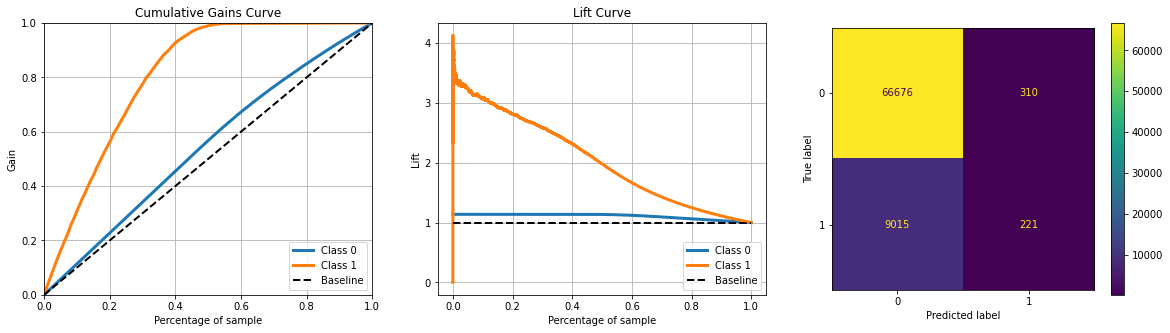

In [134]:
# plot
fig, ax = plt.subplots(1,3,figsize=(20,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_test,y_score_final_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_test,y_score_final_xgb,ax=ax[1]);
plot_confusion_matrix(xgb_model_final, x_test[cols_selected],y_test,ax=ax[2])  
plt.show() 

### Compare Validation and Test Metrics

In [135]:
aux = pd.concat([xgb_result_rank,xgb_result_final_rank],axis=0)
aux.index = ['Validation', 'Test']
aux

Model Name  Precision at K  Recall at K
Validation    XGBoost        0.326634     0.707341
Test          XGBoost        0.323934     0.701494

# 9.0 Business Result

In [154]:
# Traçando métricas com base na dataset de teste

results = pd.DataFrame()
results['score'] = y_score_final_xgb[:,1].tolist()
results['real'] = y_test.tolist()

# ordering by prediction
results = results.sort_values( 'score', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

In [155]:
def return_interest_perc(df,calls):
    perc = 100 * calls / len(df)
    return results[results['base_cum_perc'] <= perc]['real_cum_perc'].max()

## Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

1. Pessoas acima de 40 anos são 48% mais interessadas em adquirir o seguro
2. Homens possuem mais interesse em adquirir o seguro do que as mulheres
3. Pessoas que já possuiam seguro de veículo, em quase 00% dos casos, não estavam interessadas em adquirir um segundo seguro
4. Pessoas com o veículo com mais de 2 anos de idade são mais propensas a adquirir o seguro
5. Pessoas que já tiveram danos em seus carros são em sua maioria absoluta mais interessadas em adquirir o seguro

## Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, se o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [156]:
aux = return_interest_perc(results,20000)
print('{}% dos interessados será contatada se a companhia realizar 20 mil ligações'.format(round(float(aux),2)))

70.15% dos interessados será contatada se a companhia realizar 20 mil ligações


## E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

In [157]:
aux = return_interest_perc(results,40000)
print('{}% dos interessados será contatada se a companhia realizar 40 mil ligações'.format(round(float(aux),2)))

99.51% dos interessados será contatada se a companhia realizar 40 mil ligações


## Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

In [158]:
aux = results[results['real_cum_perc'] <= 80]['base_cum_perc'].max()/100 * len(results)
print('O time de vendas teria de fazer {} ligações para atingir 80% dos interessados'.format(int(aux)))

O time de vendas teria de fazer 23760 ligações para atingir 80% dos interessados


## Quantas ligações a companhia deveria fazer para maximixar o lucro?

- Considerando:
    - Um custo por ligação de RS 4.00 unidades monetárias
    - Receita por cliente igual à RS 40.00 unidades monetárias

In [212]:
revenue = 40
cac = 4

In [213]:
# gross revenue
results['gross_revenue'] = revenue * results['real']
results['gross_revenue_acumulate'] = results['gross_revenue'].cumsum()

# cost
results['cost_acumulate'] = cac * results['base']

# revenue 
results['revenue_acumulate'] = results['gross_revenue_acumulate'] - results['cost_acumulate']

In [214]:
# Traçando métricas com base na dataset de teste

baseline_results = pd.DataFrame()
baseline_results['score'] = y_score_final_xgb[:,1].tolist()
baseline_results['real'] = y_test.tolist()

# Percentage of intereset ( Propensity Score )
baseline_results['real_cum'] = baseline_results['real'].cumsum() 
baseline_results['real_cum_perc'] = 100*baseline_results['real_cum']/baseline_results['real'].sum()

# Percentage of Base ( Clients )
baseline_results['base'] = range( 1, len( baseline_results ) + 1  )
baseline_results['base_cum_perc'] = 100*baseline_results['base']/len( baseline_results )

# Basline model
baseline_results['baseline'] = baseline_results['base_cum_perc']

# gross revenue
baseline_results['gross_revenue'] = revenue * baseline_results['real']
baseline_results['gross_revenue_acumulate'] = baseline_results['gross_revenue'].cumsum()

# cost
baseline_results['cost_acumulate'] = cac * baseline_results['base']

# revenue 
baseline_results['revenue_acumulate'] = baseline_results['gross_revenue_acumulate'] - baseline_results['cost_acumulate']

In [289]:
baseline_results

score  real  real_cum  real_cum_perc   base  base_cum_perc    baseline  gross_revenue  gross_revenue_acumulate  cost_acumulate  revenue_acumulate
0      0.125935     0         0       0.000000      1       0.001312    0.001312              0                        0               4                 -4
1      0.345988     1         1       0.010827      2       0.002624    0.002624             35                       35               8                 27
2      0.087339     0         1       0.010827      3       0.003936    0.003936              0                       35              12                 23
3      0.156676     0         1       0.010827      4       0.005248    0.005248              0                       35              16                 19
4      0.273481     1         2       0.021654      5       0.006560    0.006560             35                       70              20                 50
...         ...   ...       ...            ...    ...            ...         ...            ...                      ...             ...                ...
76217  0.000567     0      9236     100.000000  76218      99.994752   99.994752              0                   323260          304872              18388
76218  0.000397     0      9236     100.000000  76219      99.996064   99.996064              0                   323260          304876              18384
76219  0.009957     0      9236     100.000000  76220      99.997376   99.997376              0                   323260          304880              18380
76220  0.000695     0      9236     100.000000  76221      99.998688   99.998688              0                   323260          304884              18376
76221  0.019692     0      9236     100.000000  76222     100.000000  100.000000              0                   323260          304888              18372

[76222 rows x 11 columns]

### Optimal result

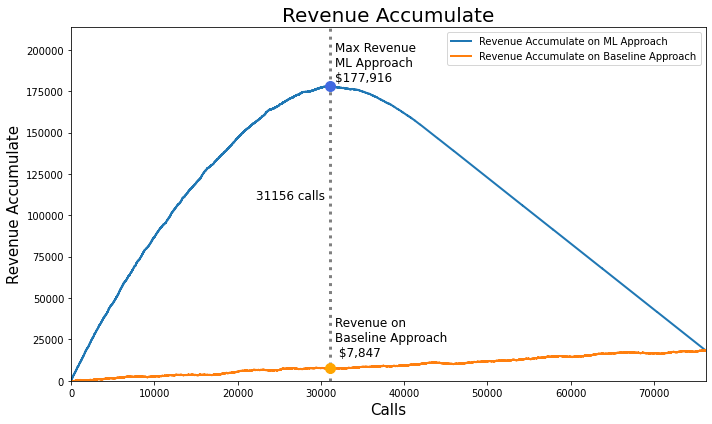

In [334]:
# set points
max_ml_revenue = results['revenue_acumulate'].max()
baseline_revenue = baseline_results.loc[optimal_number_of_clients, 'revenue_acumulate']
optimal_number_of_clients = int(results.loc[results['revenue_acumulate'] == results['revenue_acumulate'].max(), ['base']].values)

# plot figures
plt.figure( figsize=(10,6))
plt.title('Revenue Accumulate', fontsize=20)
sns.lineplot( x='base', y='revenue_acumulate', data=results, label = 'Revenue Accumulate on ML Approach',linewidth=2)
sns.lineplot( x='base', y='revenue_acumulate', data=baseline_results , label = 'Revenue Accumulate on Baseline Approach', linewidth=2 )

# optimal line
plt.axvline(x = optimal_number_of_clients, linestyle = ':',linewidth = 3, color='gray') 

# set text points
plt.text(x = optimal_number_of_clients+500, y = max_ml_revenue+3000, s='Max Revenue\nML Approach\n${:,.0f}'.format(max_ml_revenue), fontsize=12)
plt.text(x = optimal_number_of_clients+500, y = baseline_revenue+7000, s='Revenue on\nBaseline Approach\n ${:,.0f}'.format(baseline_revenue), fontsize=12)
plt.text(x = optimal_number_of_clients-9000, y = 110000, s=str(optimal_number_of_clients) + ' calls', fontsize=12)

# set points
plt.plot(optimal_number_of_clients, max_ml_revenue, 'o', color='royalblue',markersize=10)
plt.plot(optimal_number_of_clients, baseline_revenue, 'o', color='orange',markersize=10)

# set axis titles
plt.xlabel('Calls', fontsize=15)
plt.ylabel('Revenue Accumulate', fontsize=15)

# set axis limits
plt.ylim(0,max_revenue*1.2)
plt.xlim(0,results.shape[0])
plt.tight_layout()

### Expected operational results

In [352]:
int(results.loc[results['base'] == 20000, 'revenue_acumulate'])

146765

In [354]:
ml_revenue-baseline_revenue

141299

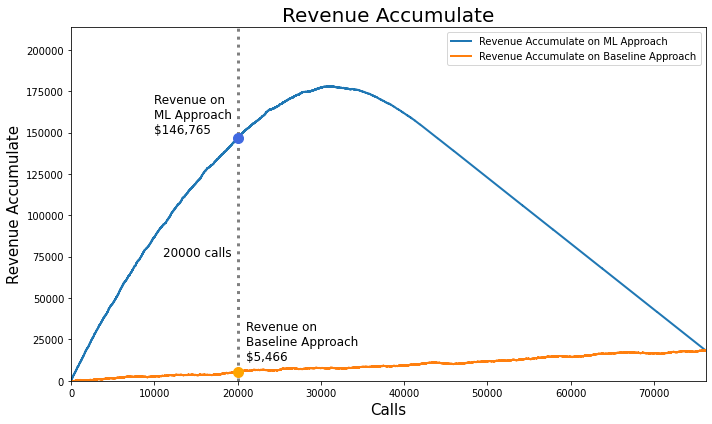

In [356]:
# set points
ml_revenue = int(results.loc[results['base'] == 20000, 'revenue_acumulate'])
baseline_revenue = baseline_results.loc[20000, 'revenue_acumulate']
n_calls = 20000

# plot figures
plt.figure( figsize=(10,6))
plt.title('Revenue Accumulate', fontsize=20)
sns.lineplot( x='base', y='revenue_acumulate', data=results, label = 'Revenue Accumulate on ML Approach',linewidth=2)
sns.lineplot( x='base', y='revenue_acumulate', data=baseline_results , label = 'Revenue Accumulate on Baseline Approach', linewidth=2 )

# optimal line
plt.axvline(x = 20000, linestyle = ':',linewidth = 3, color='gray') 

# set text points
plt.text(x = n_calls - 10000,  y = ml_revenue+3000, s='Revenue on\nML Approach\n${:,.0f}'.format(ml_revenue), fontsize=12)
plt.text(x = n_calls + 1000,  y = baseline_revenue+7000, s='Revenue on\nBaseline Approach\n${:,.0f}'.format(baseline_revenue), fontsize=12)
plt.text(x = n_calls - 9000, y = 75000, s=str(n_calls) + ' calls', fontsize=12)

# set points
plt.plot(n_calls, ml_revenue, 'o', color='royalblue',markersize=10)
plt.plot(n_calls, baseline_revenue, 'o', color='orange',markersize=10)

# set axis titles
plt.xlabel('Calls', fontsize=15)
plt.ylabel('Revenue Accumulate', fontsize=15)

# set axis limits
plt.ylim(0,max_revenue*1.2)
plt.xlim(0,results.shape[0])
plt.tight_layout()

# 10.0 Deployment

In [82]:
class HealthInsurance():
    def __init__(self):
        self.home_path = 'C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\'
        self.annual_premium_scaller      = pickle.load(open(self.path + 'src\\features\\annual_premium_scaller.pkl'))
        self.age_scaler                  = pickle.load(open(self.path + 'src\\features\\age_scaler.pkl'))
        self.vintage_scaler              = pickle.load(open(self.path + 'src\\features\\vintage_scaler.pkl'))
        self.gender_scaler               = pickle.load(open(self.path + 'src\\features\\gender_scaler.pkl'))
        self.region_code_scaler          = pickle.load(open(self.path + 'src\\features\\region_code_scaler.pkl'))
        self.policy_sales_channel_scaler = pickle.load(open(self.path + 'src\\features\\policy_sales_channel_scaler.pkl'))             
    
    def data_cleaning(self, df1):

        # region_code
        df1['region_code'] = df1['region_code'].astype('int64')

        # policy_sales_channel 
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

        return df1

    def feature_engineering(self, df2):

        # vericle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                             'between_1_2_year' if x == '1-2 Year' else 
                                                             'over_2_years')
        return df2
    
    
    def data_preparation(self, df5):

        ss = pp.StandardScaler()

        ## annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        ## 5.3 Rescaling

        ## age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        ## vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        ## 5.4 Encoder
        ### 5.4.1 One Hot Enconding

        ## vehicle_age
        df5 = pd.get_dummies(df5, prefix='vehicle_age',columns=['vehicle_age'])

        ### 5.4.2 Target Enconding

        # gender 
        df5.loc[:,'gender'] = df5['gender'].map(self.gender_scaler)

        # region_code 
        df5.loc[:,'region_code'] = df5['region_code'].map(self.region_code_scaler)

        # vehicle damage
        df5.loc[:,'vehicle_damage'] = df5['vehicle_damage'].map(self.vehicle_damage_scaler)

        ### 5.4.3 Frequency Enconding

        ## policy_sales_channel 
        df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_channel_scaler)

        cols_selected = [
                'vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']
        
        return df5[cols_selected]

    def get_predict(self, model, original_data, test_data):
        
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')
        

## 10.2. API Handler

In [83]:
# import pickle
# import pandas as pd
# from flask import Flask, request, Response
# from healthinsurance import HealthInsurance
# import xgboost as xgb

# path = 'C:\\Users\\Notebook\\repos\\Insurance-Cross-Sell\\'
# model = pickle.load(open(path + 'src//model/xgb_model.pkl','rb'))

# app = Flask(__name__)

# @app.route('/predict',methods=['POST'])
# def health_insurance_predict():
#     test_json = request.get_json()
    
#     if test_json:
#         # there is data 
#         if isinstance(test_json, dict): # unique example
#             test_raw = pd.DataFrame(test_json,index=[0])
#         else: # multiple examples
#             test_raw = pd.DataFrame(test_json,columns = test_json[0].keys())
            
#         # Instantiate HeathInsurance class
#         pipeline = HealthInsurance()

#         # data cleaning
#         df1 = pipeline.data_cleaning(test_raw)

#         # feature engineering
#         df2 = pipeline.feature_engineering(df1)

#         # data preparation
#         df3 = pipeline.data_preparation(df2)

#         # prediction
#         df_response = pipeline.get_predict(model,test_raw,df3)
    
#         return df_response
#     else:
#         return Response('{Request is empty}',status=200, mimetype='application/json')

# if __name__ == '__main__':
#     app.run('0.0.0.0')

## 10.3 API Tester

In [ ]:
X_test.head()

In [85]:
# loading test dataset
df_test = X[0:10000]
df_test['response'] = y[0:10000]

data = json.dumps(df_test.to_dict(orient='records'))

In [87]:
# url = 'http://192.168.18.4:5000/predict'

# url = 'https://insurance-crosssell-app.herokuapp.com/predict'
url = 'https://insurance-cross-sell-api.onrender.com/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [88]:
pd.DataFrame(r.json(),columns= r.json()[0].keys()).sample(30)

id  gender       age  region_code  policy_sales_channel  driving_license   vehicle_age vehicle_damage  previously_insured  annual_premium   vintage  response  prediction
1744  14233  Female  0.661538           28                    26                1  over_2_years            Yes                   0        0.230519  0.681661         0    0.229506
7913  63847    Male  0.338462           46                   124                1  over_2_years             No                   0       -1.621659  0.307958         0    0.037391
6232  50352  Female  0.076923           21                   152                1  over_2_years             No                   1        0.522248  0.602076         0    0.000148
2260  18154  Female  0.384615           28                   124                1  over_2_years            Yes                   0        1.037213  0.117647         0    0.313208
6552  52882    Male  0.353846           28                   124                1  over_2_years            Yes                   0       -0.092727  0.958478         0    0.312362
1164   9368    Male  0.061538            8                   152                1  over_2_years             No                   1        1.461745  0.802768         0    0.000253
6396  51752  Female  0.061538           41                   152                1  over_2_years             No                   1       -0.138930  0.854671         0    0.000267
930    7513    Male  0.492308           38                    26                1  over_2_years            Yes                   0       -0.197031  0.231834         0    0.294394
933    7520  Female  0.015385           50                   152                1  over_2_years            Yes                   0        0.570250  0.903114         0    0.163336
2293  18377    Male  0.907692           41                   152                1  over_2_years             No                   1        0.578144  0.771626         0    0.000128
3518  28168  Female  0.415385            7                   156                1  over_2_years            Yes                   0       -1.621659  0.878893         0    0.226198
8169  65977  Female  0.061538           28                   152                1  over_2_years             No                   1        1.661300  0.923875         0    0.001354
5322  42903  Female  0.092308           32                    26                1  over_2_years            Yes                   0       -0.244744  0.885813         0    0.191419
8334  67234    Male  0.092308           14                   152                1  over_2_years             No                   1        0.490498  0.148789         0    0.000122
3785  30290    Male  0.076923            8                   160                1  over_2_years             No                   1        0.415679  0.795848         0    0.000317
763    6212    Male  0.076923           21                   152                1  over_2_years             No                   1        0.189598  0.726644         0    0.000149
6238  50375    Male  0.030769           46                   152                1  over_2_years             No                   1        1.026184  0.871972         0    0.000249
1405  11415    Male  0.046154           36                   152                1  over_2_years            Yes                   0       -1.621659  0.038062         0    0.087331
4317  34605  Female  0.061538           46                   160                1  over_2_years             No                   1       -0.098763  0.141869         0    0.000307
4824  38879    Male  0.076923           47                   160                1  over_2_years             No                   1       -1.621659  0.207612         0    0.000443
9738  77863    Male  0.046154           15                   152                1  over_2_years            Yes                   0        0.561776  0.207612         0    0.065101
3376  26911  Female  0.553846           20                    26       